# Detección de probabilidad de impagos

<img src='https://image.cnbcfm.com/api/v1/image/106210419-1572366832669gettyimages-1137376687.jpg?v=1572366860&w=1340&h=500'>

Vamos a construir un modelo de Machine Learning que prediga la probabilidad de que un cliente sufra dificultades financieras en el futuro. 

Concretamente, el dataset con el que vamos a trabajar contempla dificultades financieras a dos años vista, por lo que nuestras predicciones serán para este rango temporal.

Los datos pertenecen a una [competición de Kaggle propuesta por la escuela The Bridge.]('https://www.kaggle.com/c/gmsc-thebridge-dsft2109/leaderboard')

## Configuración del Notebook

Vamos a configurar las visualizaciones y a importar algunas librerías que utilizaremos.

In [1]:
# Configuración de visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
# Configurando Matplotlib
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Centramos los outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}
}
</style>
""")

In [2]:
# Importando librerías
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers

## 1. Análisis Exploratorio de Datos

Vamos a cargar nuestros datasets, que están disponibles en la sección [data]('https://www.kaggle.com/c/gmsc-thebridge-dsft2109/data') de la competición.

Concretamente, tenemos dos datasets, uno de entrenamiento y otro de validación.

In [3]:
# Convertimos los datasets a Pandas DataFrames
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Como vamos a necesitar los `Id` del dataset *test*, almacenamos dicha columna en una variable, que utilizaremos a la hora de realizar la submission.

In [4]:
# Índices - Columna 'Id' del DataFrame test
indices = test['Id']

### 1.1. Valores Nulos
Vamos a comprobar si existen valores nulos en nuestros datos, y los reemplazaremos en función de la cantidad que exista y el tipo de dato del que se trate:

In [5]:
# Valores nulos - Datos de entrenamiento
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104805 entries, 0 to 104804
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Id                                    104805 non-null  int64  
 1   SeriousDlqin2yrs                      104805 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  104805 non-null  float64
 3   age                                   104805 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  104805 non-null  int64  
 5   DebtRatio                             104805 non-null  float64
 6   MonthlyIncome                         84024 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       104805 non-null  int64  
 8   NumberOfTimes90DaysLate               104805 non-null  int64  
 9   NumberRealEstateLoansOrLines          104805 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  104805 non-null  int64  
 11  

In [6]:
# Valores nulos - Datos de Validación
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45195 entries, 0 to 45194
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Id                                    45195 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  45195 non-null  float64
 2   age                                   45195 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  45195 non-null  int64  
 4   DebtRatio                             45195 non-null  float64
 5   MonthlyIncome                         36245 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       45195 non-null  int64  
 7   NumberOfTimes90DaysLate               45195 non-null  int64  
 8   NumberRealEstateLoansOrLines          45195 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  45195 non-null  int64  
 10  NumberOfDependents                    44020 non-null  float64
dtypes: float64(4), 

Ambos datasets contienen valores nulos en las columnas `MonthlyIncome` y `NumberOfDependents`. Vamos a rellenar dichos valores nulos con los valores medios y medianos (según corresponda) de cada variable.

Filtraremos los datos según la situación financiera de cada cliente —esto está representado en la columna `SeriousDlqin2yrs` de los datos de entrenamiento— y asignaremos el salario mediano de los clientes de cada situación. Para la columna `NumberOfDependents`, rellenaremos los valores nulos con la media de personas dependientes de los clientes.

In [7]:
# Ingresos medios según situación financiera del cliente
print(f"- Ingresos medios de clientes con problemas financieros: {train[train.SeriousDlqin2yrs == 1]['MonthlyIncome'].mean()}")
print(f"- Ingresos medios de clientes sin problemas financieros: {train[train.SeriousDlqin2yrs == 0]['MonthlyIncome'].mean()}")
print(" ")
# Número de personas dependientes según situación financiera del cliente
print(f"- Nº medio de personas dependientes de clientes con problemas financieros: {train[train.SeriousDlqin2yrs == 1]['NumberOfDependents'].mean()}")
print(f"- Nº medio de personas dependientes de clientes sin problemas financieros: {train[train.SeriousDlqin2yrs == 0]['NumberOfDependents'].mean()}")

- Ingresos medios de clientes con problemas financieros: 5616.206157039087
- Ingresos medios de clientes sin problemas financieros: 6763.395145829606
 
- Nº medio de personas dependientes de clientes con problemas financieros: 0.9460052677787533
- Nº medio de personas dependientes de clientes sin problemas financieros: 0.7424334712566424


In [8]:
a = pd.DataFrame(
    {'Ingresos medios': [5616, 6763],
     'Personas dependientes': [0.94, 0.74], 
     'Situación Financiera': ['Mala', 'Buena']})

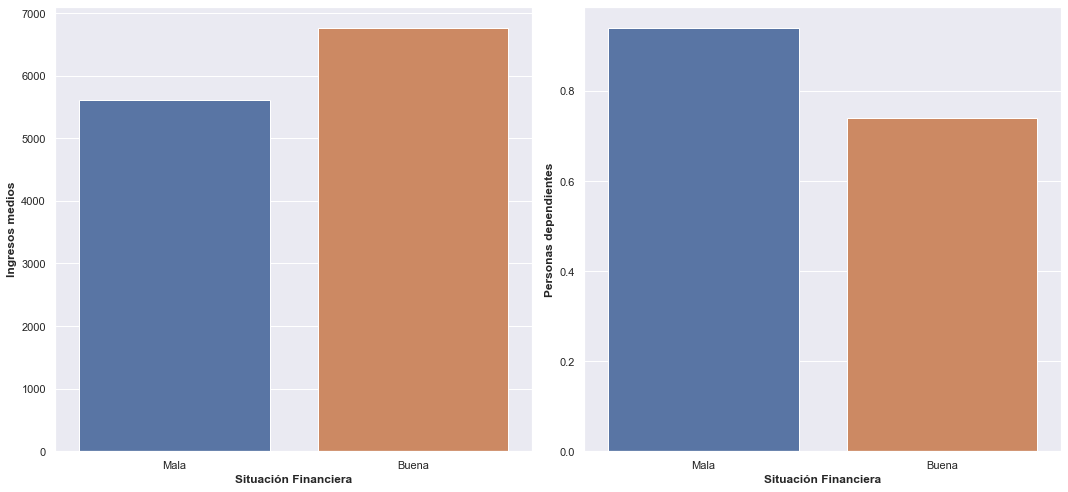

In [9]:
sns.set(rc={'figure.figsize':(15, 7)})
fig, axs = plt.subplots(ncols=2)
sns.barplot(x='Situación Financiera', y='Ingresos medios', data=a, ax=axs[0])
sns.barplot(x='Situación Financiera', y='Personas dependientes', data=a, ax=axs[1]);

In [10]:
# Rellenamos los valores nulos con los valores que acabamos de obtener

# Ingresos mensuales
# Datos de entrenamiento
monthly_income_null_fillna_1 = list(train[(train.SeriousDlqin2yrs == 1) & (train.MonthlyIncome.isnull())].index)
monthly_income_null_fillna_0 = list(train[(train.SeriousDlqin2yrs == 0) & (train.MonthlyIncome.isnull())].index)

train.loc[monthly_income_null_fillna_1, 'MonthlyIncome'] = 5616
train.loc[monthly_income_null_fillna_0, 'MonthlyIncome'] = 6763

# Datos de validación
monthly_test_null_fillna = list(test[test.MonthlyIncome.isnull()].index)

test.loc[monthly_test_null_fillna, 'MonthlyIncome'] = 5000


# Personas dependientes
# Datos de entrenamiento
dependents_null_fillna_1 = list(train[(train.SeriousDlqin2yrs == 1) & (train.NumberOfDependents.isnull())].index)
dependents_null_fillna_0 = list(train[(train.SeriousDlqin2yrs == 0) & (train.NumberOfDependents.isnull())].index)

train.loc[dependents_null_fillna_1, 'NumberOfDependents'] = 1
train.loc[dependents_null_fillna_0, 'NumberOfDependents'] = 1

# Datos de validación
dependents_test_fillna = list(test[test.NumberOfDependents.isnull()].index)

test.loc[dependents_test_fillna, 'NumberOfDependents'] = 1

Ahora eliminamos las columnas `Id` porque solo aportan ruido al modelo.

In [11]:
# Eliminamos las columnas 'Id'
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

### 1.2. Valores extraños
Vamos a eliminar filas que contengan valores extraños que podrían interferir en las predicciones de nuestro modelo:

In [12]:
# Columna 'Age' 
train.age.value_counts().sort_index(ascending=False)

109      1
105      1
103      3
102      3
101      2
      ... 
24     564
23     451
22     301
21     132
0        1
Name: age, Length: 85, dtype: int64

Solamente existen 10 personas con más de 100 años en los datos (lo que es perfectamente posible) y una persona de 0 años (también existe la posibilidad). Por tanto, mantenemos la columna intacta.

En las columnas representativas de periodos de impagos de clientes, existen valores anómalos redundantes (96 y 98, concretamente, y en las tres variables), por lo que vamos a eliminar todas las filas que contengan valores superiores a 90.

In [13]:
# Columnas 'Delays' (periodos de impagos de clientes)
train = train.drop(train[(train.NumberOfTimes90DaysLate > 20) | (train['NumberOfTime30-59DaysPastDueNotWorse'] > 20) | (train['NumberOfTime60-89DaysPastDueNotWorse'] > 20)].index)

### 1.3. Correlaciones

In [14]:
train.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

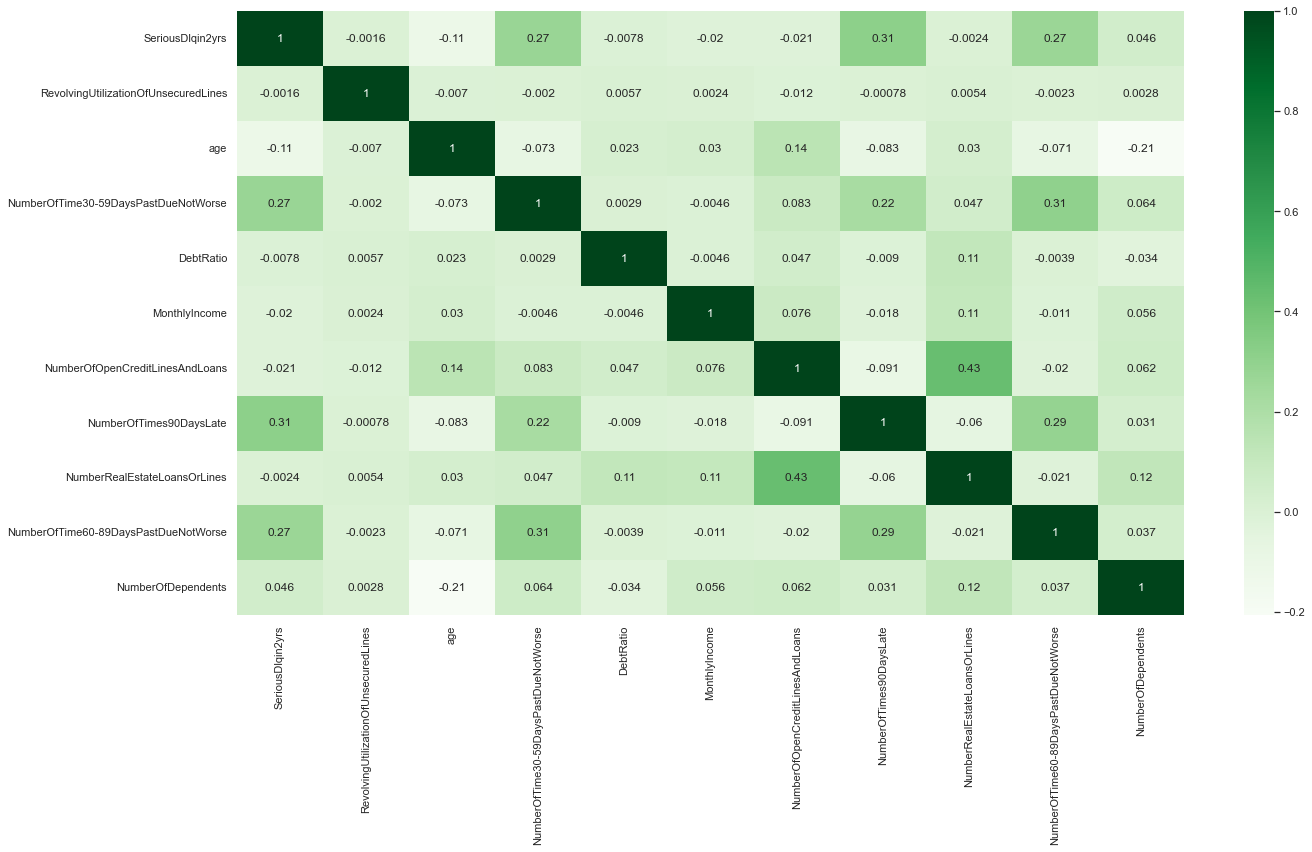

In [15]:
# Mapa de correlaciones - Datos de entrenamiento
plt.figure(figsize=(20,12))
sns.heatmap(train.corr(), annot=True, cmap='Greens');

Vemos que ninguna variable tiene correlación (en principio) con el target `SeriousDlqin2yrs`.

## 2. Preprocesamiento de Datos
Vamos a preparar los datos antes de entrenar el modelo.

In [16]:
# Target y features
X = train.drop(['SeriousDlqin2yrs'], axis=1)
y = train['SeriousDlqin2yrs']

# Dividimos los datos en datos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=14
)

# Escalado de datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test = scaler.transform(test)

## 3. Modelos de clasificación
Vamos a entrenar varios modelos y seleccionaremos el que mejor rendimiento nos ofrezca.

Como en nuestra competición la métrica utilizada es el ROC AUC Score, nos centraremos en los modelos que rindan mejor según ésta métrica.

### 3.1. ROC AUC Score
La métrica utilizada en la competición de Kaggle es el ROC AUC Score. Vamos a crear una función que reciba un modelo y devuelva el ROC AUC Score de las predicciones con datos de validación.

In [17]:
from sklearn import metrics

# En este diccionario iremos almacenando los scores de cada modelo
performance = {}

# Función para obtener el ROC AUC Score de un modelo
def roc_auc(modelo):
    '''Recibe un modelo, lo entrena con datos de entrenamiento, 
    realiza predicciones con datos de validación y devuelve el 
    ROC AUC Score y una gráfica con la curva ROC.
    '''
    # Entrenamos el modelo con datos de entrenamiento
    modelo.fit(X_train, y_train)
    # Predicciones con datos de validación
    preds = modelo.predict_proba(X_test)
    # Gráfico de la curva ROC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    display.plot()
    plt.show()
    # ROC AUC Score de las predicciones
    print(f'ROC AUC Score {modelo.__class__.__name__} :', metrics.roc_auc_score(y_test, preds[:, 1]))
    # Agregamos el Score al diccionario
    performance[modelo.__class__.__name__] = metrics.roc_auc_score(y_test, preds[:, 1])

### 3.2. Modelo 1. RandomForestClassifier

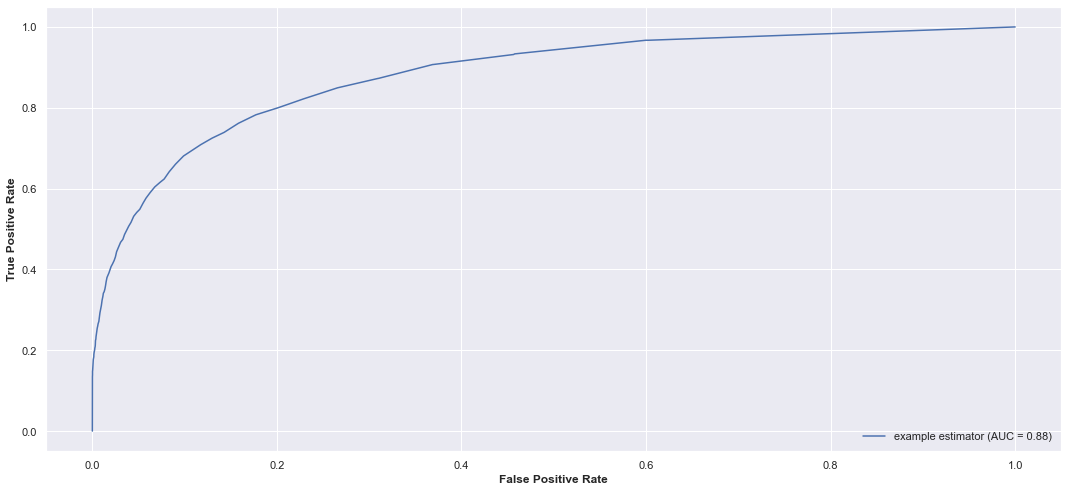

ROC AUC Score RandomForestClassifier : 0.8812838935542183


In [18]:
from sklearn.ensemble import RandomForestClassifier

# Modelo
rfc = RandomForestClassifier()

# ROC Curve y ROC AUC Score
roc_auc(rfc)

----

### 3.3. Modelo 2. XGBClassifier

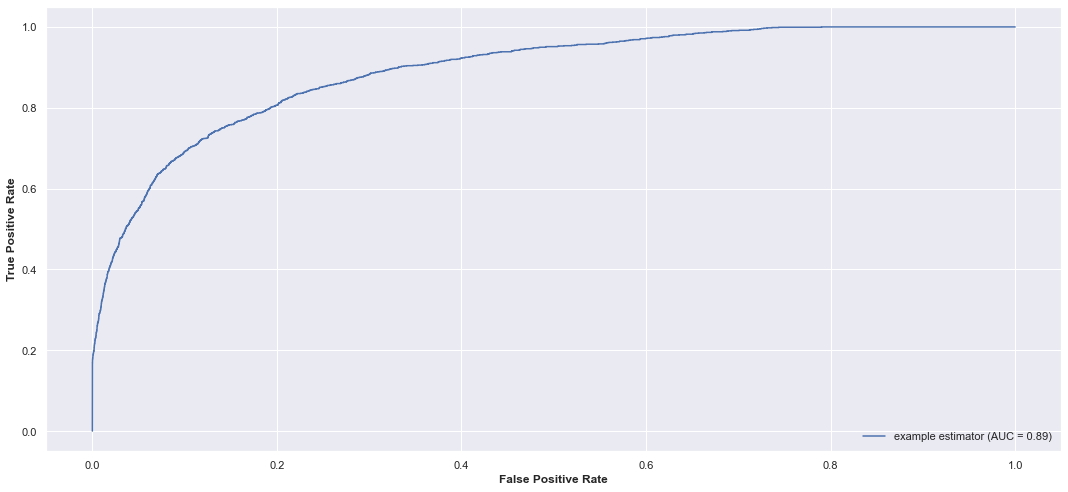

ROC AUC Score XGBClassifier : 0.8914082721795654


In [19]:
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Modelo
xgb = XGBClassifier(eval_metric='mlogloss')

# ROC Curve y ROC AUC Score
roc_auc(xgb)

----
### 3.4. KNeighborsClassifier

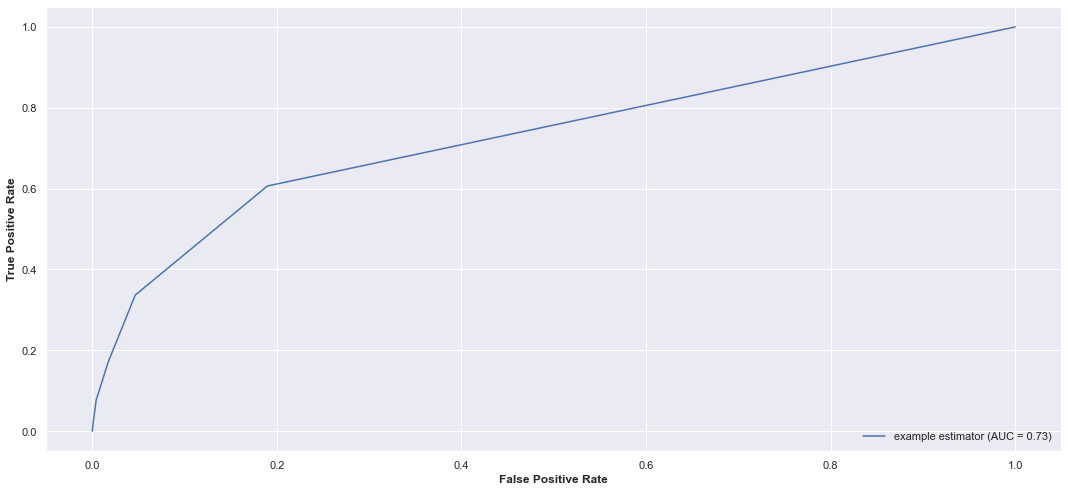

ROC AUC Score KNeighborsClassifier : 0.7275844620694094


In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Modelo
kn_clf = KNeighborsClassifier()

# ROC Curve y ROC AUC Score
roc_auc(kn_clf)

----
### 3.5. MLPClassifier

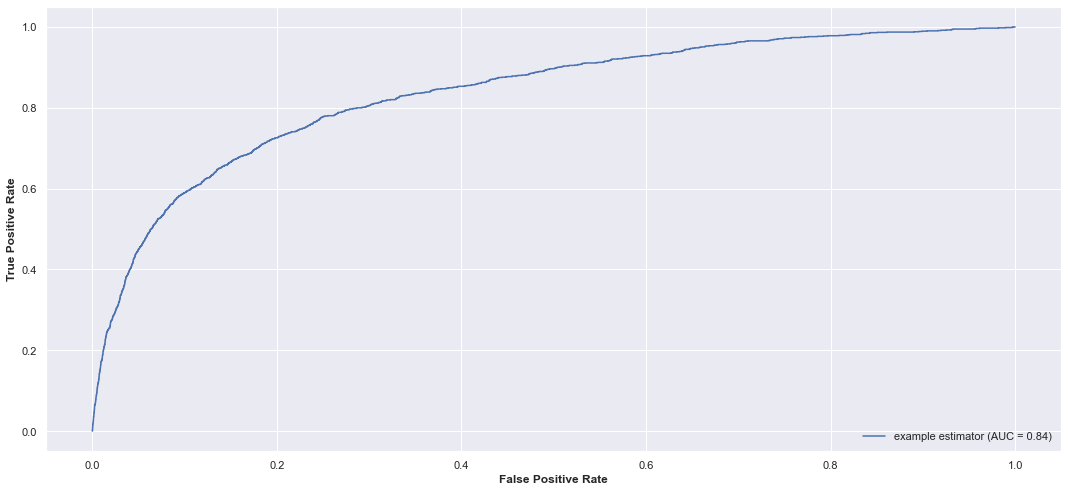

ROC AUC Score MLPClassifier : 0.8354523927357949


In [21]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

# ROC Curve y ROC AUC Score
roc_auc(mlp)

----
### 3.6. LogisticRegression

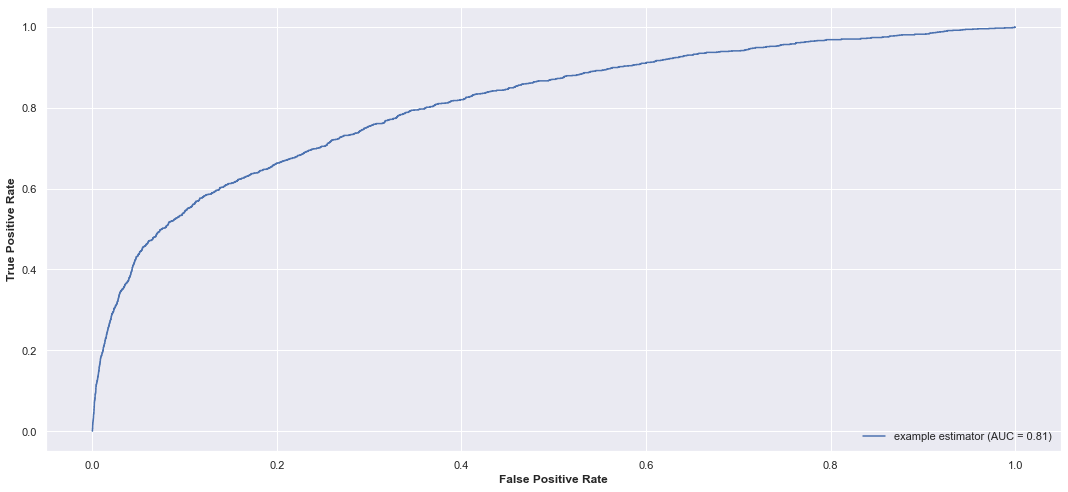

ROC AUC Score LogisticRegression : 0.8089661845612337


In [22]:
from sklearn.linear_model import LogisticRegression

# Modelo
lr = LogisticRegression(max_iter=10000)

# ROC Curve y ROC AUC Score
roc_auc(lr)

----
### 3.7. Gaussian Naive Bayes

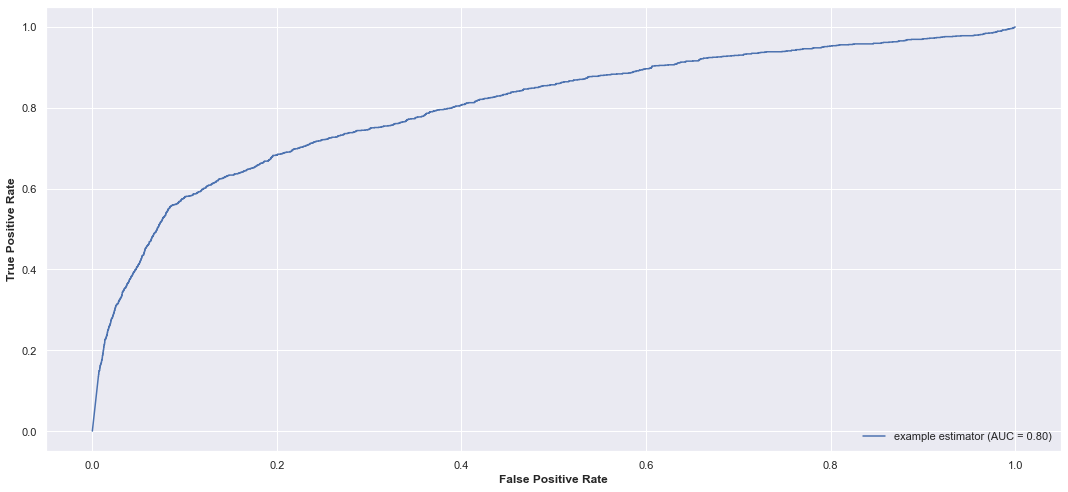

ROC AUC Score GaussianNB : 0.8027439626111094


In [23]:
from sklearn.naive_bayes import GaussianNB

# Modelo
gnb = GaussianNB()

# ROC Curve y ROC AUC Score
roc_auc(gnb)

----
### 3.8 AdaBoostClassifier

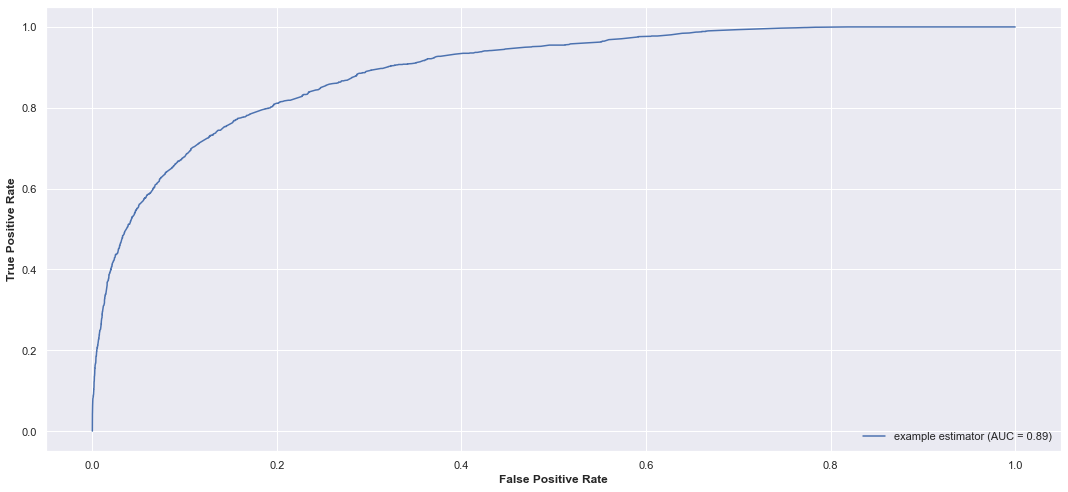

ROC AUC Score AdaBoostClassifier : 0.8922559673662225


In [24]:
from sklearn.ensemble import AdaBoostClassifier

# Modelo
abc = AdaBoostClassifier()

# ROC Curve y ROC AUC Score
roc_auc(abc)

----
### 3.9. CatBoostClassifier

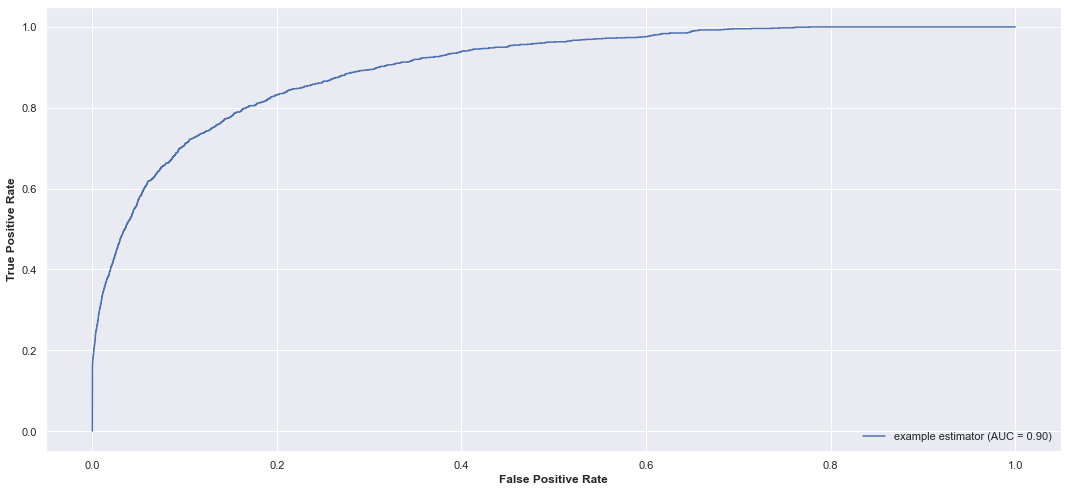

ROC AUC Score CatBoostClassifier : 0.900066976873464


In [25]:
from catboost import CatBoostClassifier

# Modelo
cbc = CatBoostClassifier(verbose=0)

# ROC Curve y ROC AUC Score
roc_auc(cbc)

In [33]:
# Creamos un Pandas DataFrame a partir de los scores obtenidos por cada modelo
scores_df = pd.DataFrame(performance, index=['ROC AUC Score']).T.sort_values('ROC AUC Score', ascending=False)
scores_df

,ROC AUC Score
CatBoostClassifier,0.900067
AdaBoostClassifier,0.892256
XGBClassifier,0.891408
RandomForestClassifier,0.881284
MLPClassifier,0.835452
LogisticRegression,0.808966
GaussianNB,0.802744
KNeighborsClassifier,0.727584


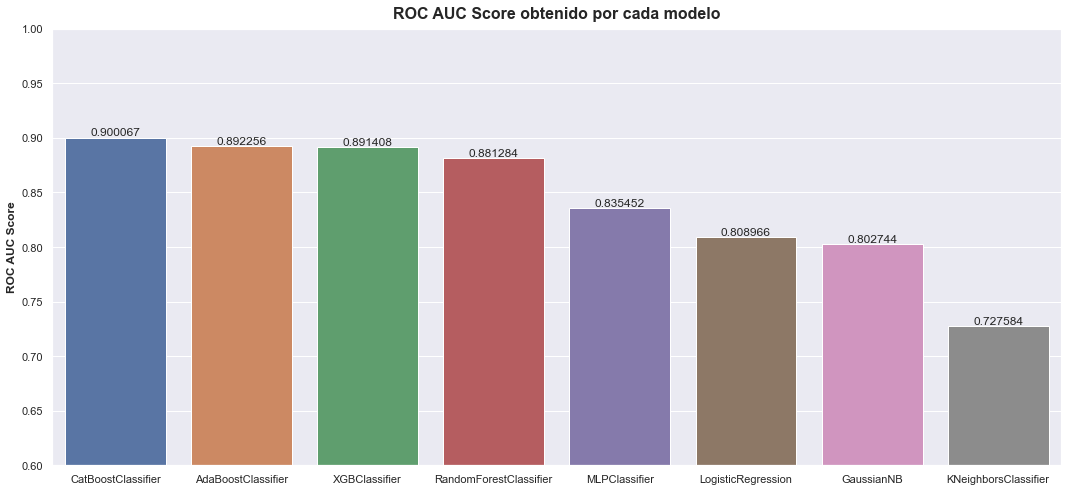

In [42]:
# Visualizamos los scores de los distintos modelos
ax = sns.barplot(x=scores_df.index, y='ROC AUC Score', data=scores_df)
ax.bar_label(ax.containers[0])
plt.ylim(0.6, 1)
plt.title('ROC AUC Score obtenido por cada modelo', fontsize=16);

----
## 4. Máximo Rendimiento
Vamos a intentar obtener el mejor score posible. Para ello, vamos a seleccionar los tres modelos que mejores resultados nos han dado, y trataremos de encontrar los mejores parámetros en cada uno de ellos, para lograr el mayor score posible en la competición.

Los modelos que mejores resultados obtuvieron fueron:

- CatBoostClassifier: 0.900
- AdaBoostClassifier: 0.892
- XGBClassifier: 0.891

Haremos un GridSearchCV con cross-validation para cada modelo y realizameros la submission con el que mayor ROC AUC Score obtenga.

### 4.1. CatBoostClassifier

In [58]:
from sklearn.model_selection import GridSearchCV

# Modelo
cat_boost = CatBoostClassifier()

# Parámetros
params = {
    'depth': [7, 8, 9], 
    'learning_rate': [0.01, 0.05, 0.1], 
}

# GridSearchCV
gridsearch = GridSearchCV(
    estimator=cat_boost,
    param_grid=params, 
    n_jobs=-1,
    cv=5,  
    scoring='roc_auc'
)

gridsearch.fit(X_train, y_train)

# Resultados del Grid Search
print('\n Mejor ROC AUC score obtenido:\n',
        gridsearch.best_score_)

print('\n Mejores parámetros:\n',
        gridsearch.best_params_)

0:	learn: 0.6777341	total: 10.7ms	remaining: 10.6s
1:	learn: 0.6595540	total: 20.1ms	remaining: 10s
2:	learn: 0.6426682	total: 29.7ms	remaining: 9.88s
3:	learn: 0.6290040	total: 39.4ms	remaining: 9.8s
4:	learn: 0.6141915	total: 49ms	remaining: 9.74s
5:	learn: 0.6010237	total: 57.4ms	remaining: 9.51s
6:	learn: 0.5863463	total: 66.4ms	remaining: 9.42s
7:	learn: 0.5741740	total: 74.8ms	remaining: 9.28s
8:	learn: 0.5594313	total: 84.4ms	remaining: 9.3s
9:	learn: 0.5453628	total: 93.5ms	remaining: 9.26s
10:	learn: 0.5343600	total: 102ms	remaining: 9.21s
11:	learn: 0.5244887	total: 109ms	remaining: 8.99s
12:	learn: 0.5142703	total: 118ms	remaining: 8.99s
13:	learn: 0.5033655	total: 128ms	remaining: 9s
14:	learn: 0.4935948	total: 138ms	remaining: 9.05s
15:	learn: 0.4855447	total: 146ms	remaining: 9s
16:	learn: 0.4764941	total: 155ms	remaining: 8.96s
17:	learn: 0.4681332	total: 164ms	remaining: 8.96s
18:	learn: 0.4571631	total: 173ms	remaining: 8.95s
19:	learn: 0.4473244	total: 182ms	remaining

### 4.2. AdaBoostClassifier

In [61]:
# Modelo
ada_boost = AdaBoostClassifier()

# Parámetros
params = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.05, 0.1],
}

# GridSearchCV
gridsearch = GridSearchCV(
    estimator=ada_boost,
    param_grid=params, 
    n_jobs=-1,
    cv=5,  
    scoring='roc_auc'
)

gridsearch.fit(X_train, y_train)

# Resultados del Grid Search
print('\n Mejor ROC AUC score obtenido:\n',
        gridsearch.best_score_)

print('\n Mejores parámetros:\n',
        gridsearch.best_params_)


 Mejor ROC AUC score obtenido:
 0.8881092155198879

 Mejores parámetros:
 {'learning_rate': 0.1, 'n_estimators': 300}


### 4.3. XGBClassifier

In [63]:
# Modelo
xgb_classifier = XGBClassifier()

# Parámetros
params = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],  
}

# GridSearchCV
gridsearch = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=params, 
    n_jobs=-1,
    cv=5,  
    scoring='roc_auc'
)

gridsearch.fit(X_train, y_train)

# Resultados del Grid Search
print('\n Mejor ROC AUC score obtenido:\n',
        gridsearch.best_score_)

print('\n Mejores parámetros:\n',
        gridsearch.best_params_)

[01:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Mejor ROC AUC score obtenido:
 0.8989948081201307

 Mejores parámetros:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [67]:
final_scores = pd.DataFrame(
    {'CatBoost': 0.9, 
     'AdaBoost': 0.88, 
     'XGBClassifier': 0.898}, index=['ROC AUC Score']).T.sort_values('ROC AUC Score', ascending=False)
final_scores

,ROC AUC Score
CatBoost,0.900
XGBClassifier,0.898
AdaBoost,0.880


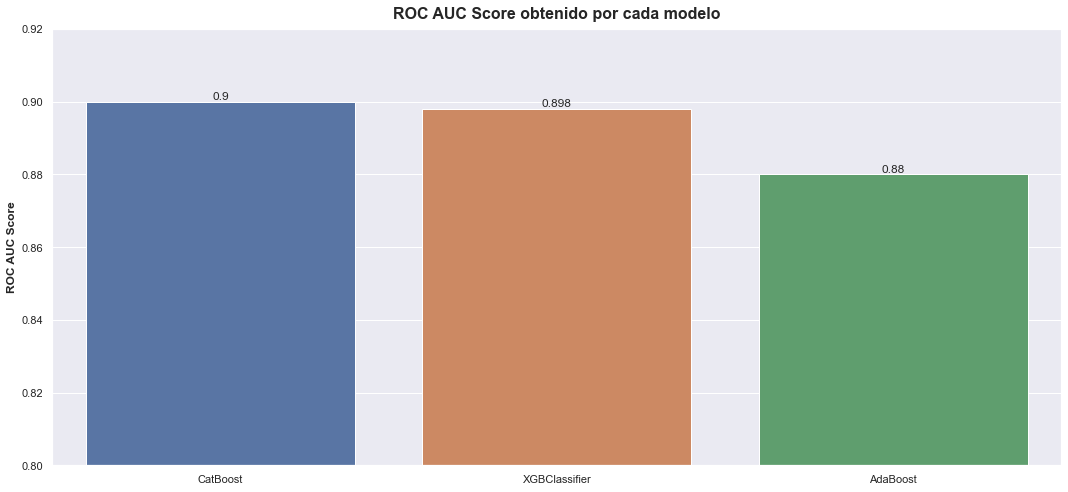

In [69]:
# Visualizamos los scores de los mejores modelos
ax = sns.barplot(x=final_scores.index, y='ROC AUC Score', data=final_scores)
ax.bar_label(ax.containers[0])
plt.ylim(0.8, 0.92)
plt.title('ROC AUC Score obtenido por cada modelo', fontsize=16);

**El modelo que utilizaremos para enviar las predicciones a Kaggle será *CatBoost* con los siguientes parámetros:**
- depth: 7
- learning_rate: 0.01

----
## 5. Submission a Kaggle
Una vez hemos tenemos identificado el mejor modelo, vamos a realizar las predicciones finales y las vamos a enviar a la competición.

In [76]:
# Modelo para realizar las predicciones definitivas
modelo_final = CatBoostClassifier(depth=7, learning_rate=0.01)
# Entrenamos el modelo con la totalidad de los datos de entrenamiento
X = scaler.transform(X)
modelo_final.fit(X, y)
# Realizamos las predicciones
predicciones_finales = modelo_final.predict_proba(test)

[01:37:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
# DataFrame que convertiremos a formato CSV
submission = pd.DataFrame(
    {'Id': indices, 
     'SeriousDlqin2yrs': predicciones_finales[:, 1]}
)

In [78]:
# Submission CSV
submission.to_csv('submission.csv', index=False)

----
## 6. Puntuación Obtenida
Tras enviar nuestras predicciones a Kaggle, hemos obtenido un ROC AUC Score de 0.79